In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import numpy as np

In [8]:
from imutils import paths


(138, 32, 32, 3)


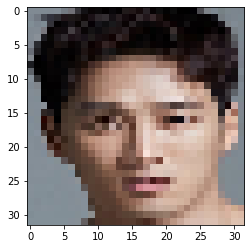

In [15]:
imagePaths = list(paths.list_images("Dataset"))
data=[]
for i in imagePaths:
#     label=i.split(os.path.sep)[-2]
#     labels.append(label)
    image = load_img(i,target_size=(32,32))
#     image = image.convert('L')
    image = img_to_array(image)
#         image = preprocess_input(image)
    data.append(image)

data = np.array(data)
plt.imshow(data[0].astype('uint8'))

data = data.astype('float32')
data = (data - 127.5) / 127.5 #BC of tanh activation of Generator
print(data.shape)



In [17]:
# load Celeb training images
def load_real_samples():

    dataset = "Dataset"
    imagePaths = list(paths.list_images(dataset))
    data=[]
    for i in imagePaths:
        image = load_img(i,target_size=(32,32))
        image = img_to_array(image)
        data.append(image)

    data = np.array(data)
    X = data.astype('float32')
    X = (X - 127.5) / 127.5

    return X

In [18]:
# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       3584      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8

In [19]:

# define the standalone generator model
# #Given input of latent vector, the Generator produces an image.(here: 32x32)
#latent_dim, for example, can be 100, 1D array of size 100 

#Here we are only using Dense and conv2dlayers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.       

def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

test_gen = define_generator(100)
print(test_gen.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 128)      

In [35]:

# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant. 
def define_gan(generator, discriminator):
    discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
    # connect generator and discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another 
#half batch of fake images. 
#For each real image we assign a label 1 and for fake we assign label 0. 
def generate_real_samples(dataset, n_samples):
    # choose random images
    ix = randint(0, dataset.shape[0], n_samples)
    # select the random images and assign it to X
    X = dataset[ix]
    # generate class labels and assign to y
    y = ones((n_samples, 1)) ##Label=1 indicating they are real
    return X, y

# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict using generator to generate fake samples. 
    X = generator.predict(x_input)
    # Class labels will be 0 as these samples are fake. 
    y = zeros((n_samples, 1))  #Label=0 indicating they are fake
    return X, y

# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator. 
#Feed both set of images into the Discriminator. 
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=4):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
    # manually enumerate epochs and bacthes. 
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            
            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
            y_gan = ones((n_batch, 1))
            
            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # Print losses on this batch
            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
    # save the generator model
    savename = "celebFaceGenerator_"+str(n_epochs)+"epochs_"+str(n_batch)+"batch.h5" 
    g_model.save(savename)


In [26]:
#Train the GAN
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)

In [27]:
dataset = load_real_samples()

In [28]:
dataset.shape

(138, 32, 32, 3)

In [39]:
epochs_trial = 150
model = train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=epochs_trial)

Epoch>1, Batch 1/34, d1=0.688, d2=0.572 g=0.774
Epoch>1, Batch 2/34, d1=0.714, d2=0.527 g=0.829
Epoch>1, Batch 3/34, d1=0.596, d2=0.602 g=0.719
Epoch>1, Batch 4/34, d1=0.441, d2=0.552 g=0.824
Epoch>1, Batch 5/34, d1=0.716, d2=0.833 g=0.845
Epoch>1, Batch 6/34, d1=0.743, d2=0.590 g=0.849
Epoch>1, Batch 7/34, d1=0.673, d2=0.573 g=0.925
Epoch>1, Batch 8/34, d1=0.729, d2=0.792 g=0.832
Epoch>1, Batch 9/34, d1=0.711, d2=0.633 g=0.842
Epoch>1, Batch 10/34, d1=0.612, d2=0.602 g=0.889
Epoch>1, Batch 11/34, d1=0.727, d2=0.554 g=0.848
Epoch>1, Batch 12/34, d1=0.537, d2=0.562 g=0.936
Epoch>1, Batch 13/34, d1=0.536, d2=0.475 g=0.832
Epoch>1, Batch 14/34, d1=0.502, d2=0.517 g=0.695
Epoch>1, Batch 15/34, d1=0.574, d2=0.637 g=0.709
Epoch>1, Batch 16/34, d1=0.596, d2=0.629 g=0.767
Epoch>1, Batch 17/34, d1=0.586, d2=0.572 g=0.723
Epoch>1, Batch 18/34, d1=0.646, d2=0.582 g=0.913
Epoch>1, Batch 19/34, d1=0.567, d2=0.693 g=0.634
Epoch>1, Batch 20/34, d1=0.437, d2=0.695 g=0.842
Epoch>1, Batch 21/34, d1=0.58

Epoch>6, Batch 2/34, d1=0.545, d2=0.927 g=0.870
Epoch>6, Batch 3/34, d1=0.581, d2=0.810 g=0.729
Epoch>6, Batch 4/34, d1=0.580, d2=0.713 g=0.935
Epoch>6, Batch 5/34, d1=0.465, d2=0.637 g=0.746
Epoch>6, Batch 6/34, d1=0.675, d2=0.607 g=1.065
Epoch>6, Batch 7/34, d1=0.601, d2=0.402 g=0.694
Epoch>6, Batch 8/34, d1=0.616, d2=0.788 g=0.688
Epoch>6, Batch 9/34, d1=0.664, d2=0.584 g=0.878
Epoch>6, Batch 10/34, d1=0.799, d2=0.621 g=0.714
Epoch>6, Batch 11/34, d1=0.577, d2=0.604 g=0.836
Epoch>6, Batch 12/34, d1=0.774, d2=0.505 g=0.747
Epoch>6, Batch 13/34, d1=0.832, d2=0.464 g=0.868
Epoch>6, Batch 14/34, d1=0.610, d2=0.772 g=0.960
Epoch>6, Batch 15/34, d1=0.500, d2=0.617 g=0.771
Epoch>6, Batch 16/34, d1=0.536, d2=0.521 g=0.932
Epoch>6, Batch 17/34, d1=0.761, d2=0.389 g=0.837
Epoch>6, Batch 18/34, d1=0.502, d2=0.511 g=0.882
Epoch>6, Batch 19/34, d1=0.549, d2=0.863 g=0.713
Epoch>6, Batch 20/34, d1=0.853, d2=0.736 g=0.779
Epoch>6, Batch 21/34, d1=0.869, d2=0.624 g=0.827
Epoch>6, Batch 22/34, d1=0.5

Epoch>11, Batch 2/34, d1=0.683, d2=0.752 g=0.869
Epoch>11, Batch 3/34, d1=0.479, d2=0.561 g=0.937
Epoch>11, Batch 4/34, d1=0.600, d2=0.588 g=0.880
Epoch>11, Batch 5/34, d1=0.769, d2=0.727 g=0.955
Epoch>11, Batch 6/34, d1=0.549, d2=0.649 g=1.046
Epoch>11, Batch 7/34, d1=0.705, d2=0.617 g=0.940
Epoch>11, Batch 8/34, d1=0.656, d2=0.667 g=0.762
Epoch>11, Batch 9/34, d1=0.525, d2=0.369 g=1.032
Epoch>11, Batch 10/34, d1=0.847, d2=0.636 g=0.994
Epoch>11, Batch 11/34, d1=0.584, d2=0.530 g=0.892
Epoch>11, Batch 12/34, d1=0.569, d2=0.965 g=0.880
Epoch>11, Batch 13/34, d1=0.667, d2=0.519 g=1.016
Epoch>11, Batch 14/34, d1=0.805, d2=0.600 g=0.604
Epoch>11, Batch 15/34, d1=0.833, d2=0.865 g=0.775
Epoch>11, Batch 16/34, d1=0.449, d2=0.777 g=0.836
Epoch>11, Batch 17/34, d1=0.717, d2=0.869 g=0.903
Epoch>11, Batch 18/34, d1=0.729, d2=0.861 g=0.734
Epoch>11, Batch 19/34, d1=0.661, d2=0.623 g=0.656
Epoch>11, Batch 20/34, d1=0.665, d2=0.745 g=0.954
Epoch>11, Batch 21/34, d1=0.535, d2=0.763 g=1.091
Epoch>11

Epoch>15, Batch 33/34, d1=0.612, d2=0.555 g=0.988
Epoch>15, Batch 34/34, d1=0.686, d2=0.502 g=1.099
Epoch>16, Batch 1/34, d1=0.893, d2=0.497 g=0.763
Epoch>16, Batch 2/34, d1=0.560, d2=0.496 g=0.729
Epoch>16, Batch 3/34, d1=0.762, d2=0.641 g=0.944
Epoch>16, Batch 4/34, d1=0.745, d2=0.617 g=0.864
Epoch>16, Batch 5/34, d1=0.809, d2=1.143 g=0.742
Epoch>16, Batch 6/34, d1=0.671, d2=0.561 g=0.601
Epoch>16, Batch 7/34, d1=0.730, d2=0.661 g=0.793
Epoch>16, Batch 8/34, d1=0.562, d2=0.490 g=0.744
Epoch>16, Batch 9/34, d1=0.607, d2=0.821 g=0.720
Epoch>16, Batch 10/34, d1=0.736, d2=0.537 g=0.632
Epoch>16, Batch 11/34, d1=0.550, d2=0.750 g=0.822
Epoch>16, Batch 12/34, d1=0.555, d2=0.684 g=0.849
Epoch>16, Batch 13/34, d1=0.674, d2=0.747 g=0.841
Epoch>16, Batch 14/34, d1=0.380, d2=0.829 g=0.745
Epoch>16, Batch 15/34, d1=1.009, d2=0.619 g=0.844
Epoch>16, Batch 16/34, d1=0.343, d2=0.782 g=0.758
Epoch>16, Batch 17/34, d1=0.788, d2=0.661 g=0.897
Epoch>16, Batch 18/34, d1=0.615, d2=0.778 g=0.842
Epoch>16,

Epoch>20, Batch 28/34, d1=0.565, d2=0.531 g=1.071
Epoch>20, Batch 29/34, d1=0.544, d2=0.477 g=0.907
Epoch>20, Batch 30/34, d1=0.641, d2=0.472 g=1.026
Epoch>20, Batch 31/34, d1=0.572, d2=0.466 g=0.732
Epoch>20, Batch 32/34, d1=0.891, d2=0.732 g=0.937
Epoch>20, Batch 33/34, d1=0.513, d2=0.817 g=0.895
Epoch>20, Batch 34/34, d1=0.691, d2=0.627 g=0.847
Epoch>21, Batch 1/34, d1=0.727, d2=0.658 g=0.808
Epoch>21, Batch 2/34, d1=0.845, d2=0.602 g=0.680
Epoch>21, Batch 3/34, d1=0.398, d2=0.444 g=0.754
Epoch>21, Batch 4/34, d1=0.599, d2=0.569 g=0.626
Epoch>21, Batch 5/34, d1=0.470, d2=0.801 g=0.752
Epoch>21, Batch 6/34, d1=0.590, d2=0.690 g=0.817
Epoch>21, Batch 7/34, d1=0.667, d2=0.648 g=0.701
Epoch>21, Batch 8/34, d1=0.503, d2=0.792 g=0.745
Epoch>21, Batch 9/34, d1=0.635, d2=0.601 g=0.744
Epoch>21, Batch 10/34, d1=0.672, d2=0.636 g=1.015
Epoch>21, Batch 11/34, d1=0.743, d2=0.614 g=0.846
Epoch>21, Batch 12/34, d1=0.608, d2=0.772 g=0.799
Epoch>21, Batch 13/34, d1=0.622, d2=0.796 g=0.967
Epoch>21,

Epoch>25, Batch 24/34, d1=0.745, d2=0.668 g=0.628
Epoch>25, Batch 25/34, d1=0.814, d2=0.801 g=0.867
Epoch>25, Batch 26/34, d1=0.572, d2=0.792 g=0.810
Epoch>25, Batch 27/34, d1=0.468, d2=0.543 g=0.873
Epoch>25, Batch 28/34, d1=0.515, d2=0.776 g=0.912
Epoch>25, Batch 29/34, d1=0.864, d2=0.568 g=0.765
Epoch>25, Batch 30/34, d1=0.734, d2=0.521 g=0.876
Epoch>25, Batch 31/34, d1=0.829, d2=0.908 g=0.836
Epoch>25, Batch 32/34, d1=0.704, d2=0.840 g=0.855
Epoch>25, Batch 33/34, d1=0.540, d2=0.496 g=0.675
Epoch>25, Batch 34/34, d1=0.614, d2=0.599 g=0.810
Epoch>26, Batch 1/34, d1=0.641, d2=0.479 g=0.898
Epoch>26, Batch 2/34, d1=0.826, d2=0.785 g=0.860
Epoch>26, Batch 3/34, d1=0.574, d2=0.621 g=0.868
Epoch>26, Batch 4/34, d1=0.613, d2=0.571 g=0.881
Epoch>26, Batch 5/34, d1=0.505, d2=0.601 g=0.927
Epoch>26, Batch 6/34, d1=0.631, d2=0.733 g=1.034
Epoch>26, Batch 7/34, d1=0.443, d2=0.687 g=0.797
Epoch>26, Batch 8/34, d1=0.840, d2=0.553 g=1.123
Epoch>26, Batch 9/34, d1=0.696, d2=0.575 g=0.843
Epoch>26,

Epoch>30, Batch 21/34, d1=0.607, d2=0.609 g=0.832
Epoch>30, Batch 22/34, d1=0.864, d2=0.757 g=0.817
Epoch>30, Batch 23/34, d1=0.688, d2=0.639 g=0.919
Epoch>30, Batch 24/34, d1=0.515, d2=0.562 g=0.664
Epoch>30, Batch 25/34, d1=0.456, d2=0.621 g=0.766
Epoch>30, Batch 26/34, d1=0.458, d2=0.559 g=0.783
Epoch>30, Batch 27/34, d1=0.529, d2=0.840 g=1.082
Epoch>30, Batch 28/34, d1=0.603, d2=0.706 g=0.685
Epoch>30, Batch 29/34, d1=0.454, d2=0.655 g=0.797
Epoch>30, Batch 30/34, d1=0.469, d2=0.544 g=0.888
Epoch>30, Batch 31/34, d1=0.512, d2=0.676 g=0.687
Epoch>30, Batch 32/34, d1=0.467, d2=0.556 g=1.045
Epoch>30, Batch 33/34, d1=0.770, d2=0.561 g=0.869
Epoch>30, Batch 34/34, d1=0.677, d2=0.910 g=0.770
Epoch>31, Batch 1/34, d1=0.579, d2=0.755 g=0.732
Epoch>31, Batch 2/34, d1=0.664, d2=0.345 g=0.857
Epoch>31, Batch 3/34, d1=0.585, d2=0.483 g=0.916
Epoch>31, Batch 4/34, d1=0.627, d2=0.612 g=0.718
Epoch>31, Batch 5/34, d1=0.527, d2=0.655 g=0.774
Epoch>31, Batch 6/34, d1=0.881, d2=0.600 g=0.834
Epoch>

Epoch>35, Batch 17/34, d1=0.678, d2=0.742 g=0.770
Epoch>35, Batch 18/34, d1=0.573, d2=0.632 g=0.764
Epoch>35, Batch 19/34, d1=0.578, d2=0.552 g=0.732
Epoch>35, Batch 20/34, d1=0.664, d2=0.514 g=0.729
Epoch>35, Batch 21/34, d1=0.615, d2=0.544 g=1.030
Epoch>35, Batch 22/34, d1=0.630, d2=0.685 g=0.759
Epoch>35, Batch 23/34, d1=0.628, d2=0.838 g=0.858
Epoch>35, Batch 24/34, d1=0.790, d2=0.743 g=1.033
Epoch>35, Batch 25/34, d1=0.610, d2=0.800 g=0.897
Epoch>35, Batch 26/34, d1=0.641, d2=0.681 g=0.923
Epoch>35, Batch 27/34, d1=0.736, d2=0.627 g=0.921
Epoch>35, Batch 28/34, d1=0.814, d2=0.400 g=0.806
Epoch>35, Batch 29/34, d1=0.661, d2=0.717 g=0.912
Epoch>35, Batch 30/34, d1=0.768, d2=0.744 g=0.854
Epoch>35, Batch 31/34, d1=0.649, d2=0.458 g=0.659
Epoch>35, Batch 32/34, d1=0.382, d2=0.559 g=0.795
Epoch>35, Batch 33/34, d1=0.687, d2=0.745 g=0.980
Epoch>35, Batch 34/34, d1=0.502, d2=0.643 g=0.986
Epoch>36, Batch 1/34, d1=1.051, d2=0.661 g=0.950
Epoch>36, Batch 2/34, d1=0.732, d2=0.588 g=0.783
Ep

Epoch>40, Batch 12/34, d1=0.680, d2=0.564 g=0.906
Epoch>40, Batch 13/34, d1=0.584, d2=0.725 g=0.845
Epoch>40, Batch 14/34, d1=0.568, d2=0.485 g=0.811
Epoch>40, Batch 15/34, d1=0.365, d2=0.826 g=0.968
Epoch>40, Batch 16/34, d1=0.695, d2=0.440 g=0.773
Epoch>40, Batch 17/34, d1=0.605, d2=0.625 g=0.835
Epoch>40, Batch 18/34, d1=0.535, d2=0.679 g=0.665
Epoch>40, Batch 19/34, d1=0.596, d2=0.837 g=0.973
Epoch>40, Batch 20/34, d1=0.923, d2=0.933 g=0.748
Epoch>40, Batch 21/34, d1=0.882, d2=0.508 g=0.811
Epoch>40, Batch 22/34, d1=0.670, d2=0.575 g=0.960
Epoch>40, Batch 23/34, d1=0.647, d2=0.475 g=0.947
Epoch>40, Batch 24/34, d1=0.665, d2=0.524 g=0.946
Epoch>40, Batch 25/34, d1=0.452, d2=0.670 g=0.850
Epoch>40, Batch 26/34, d1=0.517, d2=0.579 g=0.861
Epoch>40, Batch 27/34, d1=0.709, d2=0.494 g=0.897
Epoch>40, Batch 28/34, d1=0.782, d2=0.572 g=0.871
Epoch>40, Batch 29/34, d1=0.639, d2=0.666 g=0.866
Epoch>40, Batch 30/34, d1=0.797, d2=0.526 g=0.907
Epoch>40, Batch 31/34, d1=0.723, d2=0.690 g=0.748


Epoch>45, Batch 9/34, d1=0.270, d2=0.440 g=0.896
Epoch>45, Batch 10/34, d1=0.576, d2=0.554 g=0.927
Epoch>45, Batch 11/34, d1=0.438, d2=0.627 g=0.895
Epoch>45, Batch 12/34, d1=0.623, d2=0.725 g=0.834
Epoch>45, Batch 13/34, d1=0.692, d2=0.439 g=0.956
Epoch>45, Batch 14/34, d1=0.630, d2=0.694 g=0.893
Epoch>45, Batch 15/34, d1=0.895, d2=0.516 g=0.800
Epoch>45, Batch 16/34, d1=0.823, d2=0.519 g=0.754
Epoch>45, Batch 17/34, d1=0.482, d2=0.720 g=0.688
Epoch>45, Batch 18/34, d1=0.732, d2=0.852 g=0.849
Epoch>45, Batch 19/34, d1=0.402, d2=0.557 g=0.904
Epoch>45, Batch 20/34, d1=0.674, d2=0.725 g=0.869
Epoch>45, Batch 21/34, d1=0.638, d2=0.788 g=0.892
Epoch>45, Batch 22/34, d1=0.719, d2=0.698 g=0.895
Epoch>45, Batch 23/34, d1=0.394, d2=0.457 g=0.667
Epoch>45, Batch 24/34, d1=0.801, d2=0.539 g=0.742
Epoch>45, Batch 25/34, d1=0.429, d2=0.868 g=0.728
Epoch>45, Batch 26/34, d1=0.545, d2=0.546 g=0.583
Epoch>45, Batch 27/34, d1=0.431, d2=0.643 g=1.073
Epoch>45, Batch 28/34, d1=0.716, d2=0.628 g=0.856
E

Epoch>50, Batch 7/34, d1=0.573, d2=0.558 g=0.830
Epoch>50, Batch 8/34, d1=0.611, d2=0.505 g=0.711
Epoch>50, Batch 9/34, d1=0.505, d2=0.718 g=0.719
Epoch>50, Batch 10/34, d1=0.683, d2=0.679 g=0.911
Epoch>50, Batch 11/34, d1=0.601, d2=0.624 g=0.794
Epoch>50, Batch 12/34, d1=0.629, d2=0.663 g=0.704
Epoch>50, Batch 13/34, d1=0.531, d2=0.859 g=0.737
Epoch>50, Batch 14/34, d1=0.608, d2=0.584 g=0.852
Epoch>50, Batch 15/34, d1=0.612, d2=0.590 g=0.795
Epoch>50, Batch 16/34, d1=0.594, d2=0.694 g=0.818
Epoch>50, Batch 17/34, d1=0.744, d2=0.682 g=0.832
Epoch>50, Batch 18/34, d1=0.534, d2=0.491 g=0.940
Epoch>50, Batch 19/34, d1=0.714, d2=0.643 g=0.731
Epoch>50, Batch 20/34, d1=0.547, d2=0.660 g=0.730
Epoch>50, Batch 21/34, d1=0.368, d2=0.810 g=0.632
Epoch>50, Batch 22/34, d1=0.442, d2=0.826 g=0.717
Epoch>50, Batch 23/34, d1=0.305, d2=0.733 g=0.885
Epoch>50, Batch 24/34, d1=0.412, d2=1.118 g=0.904
Epoch>50, Batch 25/34, d1=0.574, d2=0.846 g=0.744
Epoch>50, Batch 26/34, d1=0.589, d2=0.483 g=0.744
Epo

Epoch>55, Batch 4/34, d1=0.408, d2=0.451 g=0.763
Epoch>55, Batch 5/34, d1=0.576, d2=0.335 g=0.792
Epoch>55, Batch 6/34, d1=0.838, d2=0.886 g=0.746
Epoch>55, Batch 7/34, d1=0.578, d2=0.730 g=0.791
Epoch>55, Batch 8/34, d1=0.473, d2=0.627 g=0.824
Epoch>55, Batch 9/34, d1=0.563, d2=0.714 g=1.289
Epoch>55, Batch 10/34, d1=0.874, d2=0.927 g=0.752
Epoch>55, Batch 11/34, d1=0.710, d2=0.520 g=1.040
Epoch>55, Batch 12/34, d1=0.834, d2=0.655 g=0.837
Epoch>55, Batch 13/34, d1=0.856, d2=0.575 g=0.738
Epoch>55, Batch 14/34, d1=0.780, d2=0.641 g=0.798
Epoch>55, Batch 15/34, d1=0.541, d2=0.704 g=0.743
Epoch>55, Batch 16/34, d1=0.614, d2=0.971 g=0.948
Epoch>55, Batch 17/34, d1=0.624, d2=0.489 g=0.643
Epoch>55, Batch 18/34, d1=0.536, d2=0.545 g=0.773
Epoch>55, Batch 19/34, d1=0.957, d2=0.598 g=0.743
Epoch>55, Batch 20/34, d1=0.643, d2=0.594 g=0.825
Epoch>55, Batch 21/34, d1=0.726, d2=0.684 g=0.737
Epoch>55, Batch 22/34, d1=0.560, d2=0.813 g=0.715
Epoch>55, Batch 23/34, d1=0.821, d2=0.882 g=0.866
Epoch>

Epoch>59, Batch 34/34, d1=0.459, d2=0.431 g=0.987
Epoch>60, Batch 1/34, d1=0.987, d2=0.693 g=1.216
Epoch>60, Batch 2/34, d1=0.856, d2=0.550 g=0.888
Epoch>60, Batch 3/34, d1=0.459, d2=0.604 g=0.959
Epoch>60, Batch 4/34, d1=0.688, d2=0.574 g=1.127
Epoch>60, Batch 5/34, d1=0.435, d2=0.542 g=0.972
Epoch>60, Batch 6/34, d1=0.564, d2=0.525 g=1.079
Epoch>60, Batch 7/34, d1=0.734, d2=0.494 g=1.015
Epoch>60, Batch 8/34, d1=0.664, d2=0.412 g=1.080
Epoch>60, Batch 9/34, d1=0.456, d2=0.408 g=0.931
Epoch>60, Batch 10/34, d1=0.458, d2=0.505 g=1.073
Epoch>60, Batch 11/34, d1=0.973, d2=0.575 g=0.911
Epoch>60, Batch 12/34, d1=0.686, d2=0.551 g=0.785
Epoch>60, Batch 13/34, d1=0.704, d2=0.507 g=0.715
Epoch>60, Batch 14/34, d1=0.669, d2=0.717 g=0.733
Epoch>60, Batch 15/34, d1=0.440, d2=0.516 g=0.685
Epoch>60, Batch 16/34, d1=0.820, d2=0.789 g=0.724
Epoch>60, Batch 17/34, d1=0.734, d2=0.667 g=0.936
Epoch>60, Batch 18/34, d1=0.497, d2=0.858 g=0.709
Epoch>60, Batch 19/34, d1=0.621, d2=0.641 g=0.806
Epoch>60,

Epoch>64, Batch 29/34, d1=0.406, d2=0.393 g=0.834
Epoch>64, Batch 30/34, d1=0.846, d2=0.588 g=0.898
Epoch>64, Batch 31/34, d1=0.686, d2=0.732 g=0.626
Epoch>64, Batch 32/34, d1=0.508, d2=0.646 g=0.768
Epoch>64, Batch 33/34, d1=0.483, d2=0.730 g=0.697
Epoch>64, Batch 34/34, d1=0.677, d2=0.690 g=0.839
Epoch>65, Batch 1/34, d1=0.420, d2=0.757 g=0.720
Epoch>65, Batch 2/34, d1=0.761, d2=0.679 g=0.857
Epoch>65, Batch 3/34, d1=0.712, d2=0.670 g=0.693
Epoch>65, Batch 4/34, d1=0.509, d2=0.690 g=0.567
Epoch>65, Batch 5/34, d1=0.608, d2=0.603 g=0.722
Epoch>65, Batch 6/34, d1=0.671, d2=1.035 g=0.683
Epoch>65, Batch 7/34, d1=0.805, d2=0.532 g=0.656
Epoch>65, Batch 8/34, d1=0.397, d2=0.945 g=0.741
Epoch>65, Batch 9/34, d1=0.816, d2=0.441 g=0.929
Epoch>65, Batch 10/34, d1=0.644, d2=0.670 g=0.789
Epoch>65, Batch 11/34, d1=0.334, d2=0.604 g=0.834
Epoch>65, Batch 12/34, d1=0.738, d2=0.665 g=0.784
Epoch>65, Batch 13/34, d1=0.578, d2=0.573 g=0.880
Epoch>65, Batch 14/34, d1=0.610, d2=1.042 g=0.994
Epoch>65,

Epoch>69, Batch 26/34, d1=0.607, d2=0.743 g=0.964
Epoch>69, Batch 27/34, d1=0.469, d2=0.513 g=1.021
Epoch>69, Batch 28/34, d1=0.675, d2=0.703 g=0.939
Epoch>69, Batch 29/34, d1=0.747, d2=0.618 g=0.802
Epoch>69, Batch 30/34, d1=0.562, d2=0.846 g=0.863
Epoch>69, Batch 31/34, d1=0.616, d2=0.451 g=1.050
Epoch>69, Batch 32/34, d1=0.541, d2=0.751 g=0.960
Epoch>69, Batch 33/34, d1=0.663, d2=0.528 g=0.720
Epoch>69, Batch 34/34, d1=0.507, d2=0.649 g=0.945
Epoch>70, Batch 1/34, d1=0.483, d2=0.472 g=0.887
Epoch>70, Batch 2/34, d1=0.636, d2=0.552 g=0.822
Epoch>70, Batch 3/34, d1=0.654, d2=0.543 g=0.833
Epoch>70, Batch 4/34, d1=0.939, d2=0.906 g=0.827
Epoch>70, Batch 5/34, d1=0.691, d2=0.607 g=0.828
Epoch>70, Batch 6/34, d1=0.337, d2=0.724 g=0.939
Epoch>70, Batch 7/34, d1=0.587, d2=0.666 g=0.901
Epoch>70, Batch 8/34, d1=0.364, d2=0.445 g=1.121
Epoch>70, Batch 9/34, d1=0.624, d2=0.466 g=0.860
Epoch>70, Batch 10/34, d1=0.931, d2=0.616 g=0.872
Epoch>70, Batch 11/34, d1=0.535, d2=0.531 g=0.934
Epoch>70,

Epoch>74, Batch 23/34, d1=0.524, d2=0.473 g=0.857
Epoch>74, Batch 24/34, d1=0.627, d2=0.603 g=0.620
Epoch>74, Batch 25/34, d1=0.371, d2=0.881 g=0.664
Epoch>74, Batch 26/34, d1=0.634, d2=0.345 g=0.712
Epoch>74, Batch 27/34, d1=0.800, d2=0.625 g=0.894
Epoch>74, Batch 28/34, d1=0.726, d2=0.519 g=0.858
Epoch>74, Batch 29/34, d1=0.587, d2=0.675 g=0.608
Epoch>74, Batch 30/34, d1=0.658, d2=0.702 g=0.999
Epoch>74, Batch 31/34, d1=0.444, d2=0.660 g=0.817
Epoch>74, Batch 32/34, d1=0.526, d2=0.689 g=1.019
Epoch>74, Batch 33/34, d1=0.640, d2=0.572 g=0.887
Epoch>74, Batch 34/34, d1=0.501, d2=0.507 g=1.008
Epoch>75, Batch 1/34, d1=0.764, d2=0.455 g=0.943
Epoch>75, Batch 2/34, d1=0.611, d2=0.761 g=0.833
Epoch>75, Batch 3/34, d1=0.668, d2=0.640 g=0.712
Epoch>75, Batch 4/34, d1=0.637, d2=0.640 g=0.876
Epoch>75, Batch 5/34, d1=0.526, d2=0.689 g=1.053
Epoch>75, Batch 6/34, d1=0.711, d2=0.618 g=0.855
Epoch>75, Batch 7/34, d1=0.706, d2=0.502 g=1.049
Epoch>75, Batch 8/34, d1=0.455, d2=0.546 g=0.857
Epoch>75

Epoch>79, Batch 18/34, d1=0.524, d2=0.722 g=0.811
Epoch>79, Batch 19/34, d1=0.626, d2=0.882 g=0.697
Epoch>79, Batch 20/34, d1=0.430, d2=0.554 g=1.037
Epoch>79, Batch 21/34, d1=0.369, d2=0.640 g=0.963
Epoch>79, Batch 22/34, d1=0.607, d2=0.473 g=0.859
Epoch>79, Batch 23/34, d1=0.615, d2=0.467 g=0.765
Epoch>79, Batch 24/34, d1=0.285, d2=0.605 g=0.776
Epoch>79, Batch 25/34, d1=0.732, d2=0.492 g=0.791
Epoch>79, Batch 26/34, d1=0.507, d2=0.551 g=0.923
Epoch>79, Batch 27/34, d1=0.710, d2=0.582 g=1.053
Epoch>79, Batch 28/34, d1=0.632, d2=0.479 g=1.173
Epoch>79, Batch 29/34, d1=0.511, d2=0.407 g=1.178
Epoch>79, Batch 30/34, d1=0.702, d2=0.662 g=0.948
Epoch>79, Batch 31/34, d1=0.554, d2=0.677 g=1.450
Epoch>79, Batch 32/34, d1=0.341, d2=0.873 g=0.872
Epoch>79, Batch 33/34, d1=1.194, d2=0.301 g=1.110
Epoch>79, Batch 34/34, d1=0.876, d2=0.598 g=0.799
Epoch>80, Batch 1/34, d1=0.474, d2=0.659 g=0.650
Epoch>80, Batch 2/34, d1=0.732, d2=0.435 g=0.733
Epoch>80, Batch 3/34, d1=0.540, d2=0.923 g=0.799
Epo

Epoch>84, Batch 13/34, d1=0.664, d2=0.587 g=0.712
Epoch>84, Batch 14/34, d1=0.359, d2=0.577 g=0.977
Epoch>84, Batch 15/34, d1=0.673, d2=0.455 g=0.888
Epoch>84, Batch 16/34, d1=0.726, d2=0.396 g=0.854
Epoch>84, Batch 17/34, d1=0.730, d2=0.502 g=0.955
Epoch>84, Batch 18/34, d1=0.629, d2=0.782 g=0.658
Epoch>84, Batch 19/34, d1=0.700, d2=0.731 g=0.736
Epoch>84, Batch 20/34, d1=0.626, d2=0.815 g=0.781
Epoch>84, Batch 21/34, d1=0.408, d2=0.639 g=0.939
Epoch>84, Batch 22/34, d1=0.321, d2=0.417 g=1.125
Epoch>84, Batch 23/34, d1=0.636, d2=0.536 g=0.900
Epoch>84, Batch 24/34, d1=0.812, d2=0.616 g=0.824
Epoch>84, Batch 25/34, d1=0.508, d2=0.376 g=0.769
Epoch>84, Batch 26/34, d1=0.316, d2=0.922 g=0.801
Epoch>84, Batch 27/34, d1=0.818, d2=0.559 g=0.735
Epoch>84, Batch 28/34, d1=0.600, d2=0.569 g=0.957
Epoch>84, Batch 29/34, d1=0.443, d2=0.463 g=0.639
Epoch>84, Batch 30/34, d1=0.697, d2=0.550 g=0.938
Epoch>84, Batch 31/34, d1=0.393, d2=0.704 g=1.166
Epoch>84, Batch 32/34, d1=0.528, d2=0.591 g=0.873


Epoch>89, Batch 10/34, d1=0.693, d2=0.527 g=0.848
Epoch>89, Batch 11/34, d1=0.752, d2=0.467 g=1.260
Epoch>89, Batch 12/34, d1=0.493, d2=0.901 g=0.854
Epoch>89, Batch 13/34, d1=0.786, d2=0.574 g=0.954
Epoch>89, Batch 14/34, d1=0.548, d2=0.607 g=0.898
Epoch>89, Batch 15/34, d1=0.600, d2=0.465 g=0.840
Epoch>89, Batch 16/34, d1=0.567, d2=0.721 g=0.844
Epoch>89, Batch 17/34, d1=0.948, d2=0.844 g=0.822
Epoch>89, Batch 18/34, d1=0.638, d2=0.482 g=1.068
Epoch>89, Batch 19/34, d1=0.642, d2=0.509 g=0.750
Epoch>89, Batch 20/34, d1=0.822, d2=0.622 g=0.742
Epoch>89, Batch 21/34, d1=0.613, d2=1.057 g=0.860
Epoch>89, Batch 22/34, d1=0.622, d2=0.388 g=0.940
Epoch>89, Batch 23/34, d1=0.534, d2=0.507 g=1.154
Epoch>89, Batch 24/34, d1=0.554, d2=0.610 g=0.709
Epoch>89, Batch 25/34, d1=0.702, d2=0.458 g=0.697
Epoch>89, Batch 26/34, d1=0.436, d2=0.782 g=0.869
Epoch>89, Batch 27/34, d1=0.355, d2=0.544 g=0.923
Epoch>89, Batch 28/34, d1=0.496, d2=0.915 g=0.791
Epoch>89, Batch 29/34, d1=0.505, d2=0.554 g=0.831


Epoch>94, Batch 7/34, d1=0.403, d2=0.456 g=1.138
Epoch>94, Batch 8/34, d1=0.483, d2=0.399 g=1.076
Epoch>94, Batch 9/34, d1=0.854, d2=0.474 g=0.978
Epoch>94, Batch 10/34, d1=0.717, d2=0.693 g=0.809
Epoch>94, Batch 11/34, d1=0.662, d2=0.632 g=0.928
Epoch>94, Batch 12/34, d1=0.702, d2=0.559 g=1.201
Epoch>94, Batch 13/34, d1=0.506, d2=0.597 g=1.115
Epoch>94, Batch 14/34, d1=0.873, d2=0.350 g=0.812
Epoch>94, Batch 15/34, d1=0.620, d2=0.696 g=0.937
Epoch>94, Batch 16/34, d1=0.603, d2=0.680 g=1.007
Epoch>94, Batch 17/34, d1=0.522, d2=0.668 g=0.795
Epoch>94, Batch 18/34, d1=0.617, d2=0.373 g=0.788
Epoch>94, Batch 19/34, d1=0.442, d2=0.667 g=1.060
Epoch>94, Batch 20/34, d1=0.302, d2=0.629 g=1.063
Epoch>94, Batch 21/34, d1=0.813, d2=0.798 g=1.088
Epoch>94, Batch 22/34, d1=0.513, d2=0.576 g=1.035
Epoch>94, Batch 23/34, d1=0.609, d2=0.453 g=1.167
Epoch>94, Batch 24/34, d1=0.440, d2=0.471 g=1.072
Epoch>94, Batch 25/34, d1=0.989, d2=0.299 g=1.063
Epoch>94, Batch 26/34, d1=0.775, d2=0.509 g=0.923
Epo

Epoch>99, Batch 5/34, d1=0.489, d2=0.813 g=1.122
Epoch>99, Batch 6/34, d1=0.768, d2=0.632 g=0.789
Epoch>99, Batch 7/34, d1=0.416, d2=0.666 g=1.262
Epoch>99, Batch 8/34, d1=0.525, d2=0.491 g=0.897
Epoch>99, Batch 9/34, d1=0.557, d2=0.282 g=0.721
Epoch>99, Batch 10/34, d1=0.615, d2=0.450 g=0.863
Epoch>99, Batch 11/34, d1=0.655, d2=1.013 g=1.031
Epoch>99, Batch 12/34, d1=0.501, d2=0.562 g=0.784
Epoch>99, Batch 13/34, d1=0.546, d2=0.657 g=0.760
Epoch>99, Batch 14/34, d1=0.690, d2=0.602 g=0.985
Epoch>99, Batch 15/34, d1=0.719, d2=0.384 g=0.868
Epoch>99, Batch 16/34, d1=0.612, d2=0.580 g=0.975
Epoch>99, Batch 17/34, d1=0.512, d2=0.779 g=0.929
Epoch>99, Batch 18/34, d1=0.519, d2=0.413 g=1.293
Epoch>99, Batch 19/34, d1=0.482, d2=0.426 g=1.048
Epoch>99, Batch 20/34, d1=0.685, d2=0.665 g=1.200
Epoch>99, Batch 21/34, d1=0.483, d2=0.373 g=1.272
Epoch>99, Batch 22/34, d1=0.717, d2=0.629 g=0.972
Epoch>99, Batch 23/34, d1=0.246, d2=0.517 g=0.882
Epoch>99, Batch 24/34, d1=0.603, d2=0.530 g=0.932
Epoch

Epoch>103, Batch 33/34, d1=0.983, d2=0.877 g=0.935
Epoch>103, Batch 34/34, d1=0.452, d2=0.838 g=0.904
Epoch>104, Batch 1/34, d1=0.565, d2=0.596 g=0.963
Epoch>104, Batch 2/34, d1=0.816, d2=0.358 g=1.122
Epoch>104, Batch 3/34, d1=0.530, d2=0.515 g=1.110
Epoch>104, Batch 4/34, d1=0.419, d2=0.361 g=0.990
Epoch>104, Batch 5/34, d1=0.422, d2=0.661 g=1.044
Epoch>104, Batch 6/34, d1=0.895, d2=0.955 g=0.948
Epoch>104, Batch 7/34, d1=0.594, d2=0.572 g=1.066
Epoch>104, Batch 8/34, d1=0.534, d2=0.607 g=0.774
Epoch>104, Batch 9/34, d1=0.722, d2=0.481 g=1.015
Epoch>104, Batch 10/34, d1=0.608, d2=0.520 g=0.974
Epoch>104, Batch 11/34, d1=0.797, d2=0.608 g=0.847
Epoch>104, Batch 12/34, d1=0.594, d2=0.517 g=0.812
Epoch>104, Batch 13/34, d1=0.301, d2=0.802 g=1.085
Epoch>104, Batch 14/34, d1=0.774, d2=0.318 g=0.627
Epoch>104, Batch 15/34, d1=0.848, d2=0.659 g=1.112
Epoch>104, Batch 16/34, d1=0.520, d2=0.684 g=0.756
Epoch>104, Batch 17/34, d1=0.440, d2=0.397 g=0.847
Epoch>104, Batch 18/34, d1=0.262, d2=0.8

Epoch>108, Batch 26/34, d1=0.438, d2=0.425 g=0.821
Epoch>108, Batch 27/34, d1=0.763, d2=0.615 g=0.697
Epoch>108, Batch 28/34, d1=0.482, d2=0.808 g=0.899
Epoch>108, Batch 29/34, d1=0.483, d2=0.524 g=1.109
Epoch>108, Batch 30/34, d1=0.534, d2=0.460 g=0.904
Epoch>108, Batch 31/34, d1=0.262, d2=0.305 g=0.897
Epoch>108, Batch 32/34, d1=0.907, d2=0.578 g=1.042
Epoch>108, Batch 33/34, d1=0.769, d2=0.621 g=0.874
Epoch>108, Batch 34/34, d1=0.175, d2=0.559 g=0.708
Epoch>109, Batch 1/34, d1=0.443, d2=0.613 g=0.899
Epoch>109, Batch 2/34, d1=0.486, d2=0.580 g=0.905
Epoch>109, Batch 3/34, d1=0.911, d2=0.435 g=0.810
Epoch>109, Batch 4/34, d1=0.368, d2=0.300 g=0.843
Epoch>109, Batch 5/34, d1=0.610, d2=0.896 g=0.876
Epoch>109, Batch 6/34, d1=0.433, d2=0.512 g=0.967
Epoch>109, Batch 7/34, d1=0.571, d2=0.569 g=0.970
Epoch>109, Batch 8/34, d1=0.387, d2=0.645 g=0.898
Epoch>109, Batch 9/34, d1=0.611, d2=0.548 g=0.791
Epoch>109, Batch 10/34, d1=0.398, d2=0.644 g=1.369
Epoch>109, Batch 11/34, d1=0.624, d2=0.4

Epoch>113, Batch 18/34, d1=0.435, d2=0.974 g=1.015
Epoch>113, Batch 19/34, d1=0.648, d2=0.373 g=0.978
Epoch>113, Batch 20/34, d1=0.554, d2=0.684 g=0.996
Epoch>113, Batch 21/34, d1=0.520, d2=0.846 g=0.969
Epoch>113, Batch 22/34, d1=0.575, d2=0.349 g=0.975
Epoch>113, Batch 23/34, d1=0.579, d2=0.327 g=0.814
Epoch>113, Batch 24/34, d1=0.595, d2=0.341 g=0.601
Epoch>113, Batch 25/34, d1=0.414, d2=0.477 g=1.336
Epoch>113, Batch 26/34, d1=0.483, d2=0.503 g=0.855
Epoch>113, Batch 27/34, d1=0.306, d2=0.500 g=0.830
Epoch>113, Batch 28/34, d1=0.760, d2=0.699 g=0.584
Epoch>113, Batch 29/34, d1=0.394, d2=0.614 g=0.692
Epoch>113, Batch 30/34, d1=0.570, d2=1.112 g=0.738
Epoch>113, Batch 31/34, d1=0.432, d2=0.240 g=1.119
Epoch>113, Batch 32/34, d1=0.341, d2=0.574 g=0.943
Epoch>113, Batch 33/34, d1=0.453, d2=0.590 g=0.712
Epoch>113, Batch 34/34, d1=0.364, d2=0.953 g=0.592
Epoch>114, Batch 1/34, d1=0.349, d2=0.839 g=0.774
Epoch>114, Batch 2/34, d1=1.379, d2=0.762 g=0.931
Epoch>114, Batch 3/34, d1=0.359, 

Epoch>118, Batch 11/34, d1=0.388, d2=0.320 g=0.849
Epoch>118, Batch 12/34, d1=0.504, d2=0.673 g=0.664
Epoch>118, Batch 13/34, d1=0.660, d2=1.076 g=0.804
Epoch>118, Batch 14/34, d1=1.032, d2=0.572 g=1.231
Epoch>118, Batch 15/34, d1=0.536, d2=0.570 g=0.742
Epoch>118, Batch 16/34, d1=0.475, d2=0.555 g=0.993
Epoch>118, Batch 17/34, d1=0.557, d2=0.940 g=0.694
Epoch>118, Batch 18/34, d1=0.511, d2=0.371 g=0.828
Epoch>118, Batch 19/34, d1=0.745, d2=0.463 g=1.199
Epoch>118, Batch 20/34, d1=0.536, d2=0.505 g=0.872
Epoch>118, Batch 21/34, d1=0.544, d2=0.445 g=0.941
Epoch>118, Batch 22/34, d1=0.574, d2=0.602 g=0.905
Epoch>118, Batch 23/34, d1=0.482, d2=0.545 g=0.926
Epoch>118, Batch 24/34, d1=0.485, d2=0.768 g=1.140
Epoch>118, Batch 25/34, d1=0.497, d2=0.685 g=0.821
Epoch>118, Batch 26/34, d1=0.328, d2=0.655 g=1.093
Epoch>118, Batch 27/34, d1=0.209, d2=0.643 g=1.110
Epoch>118, Batch 28/34, d1=0.568, d2=0.587 g=1.047
Epoch>118, Batch 29/34, d1=0.649, d2=0.459 g=0.863
Epoch>118, Batch 30/34, d1=0.48

Epoch>123, Batch 5/34, d1=0.693, d2=0.802 g=0.814
Epoch>123, Batch 6/34, d1=0.570, d2=0.497 g=0.957
Epoch>123, Batch 7/34, d1=0.481, d2=0.546 g=0.902
Epoch>123, Batch 8/34, d1=0.550, d2=0.460 g=0.820
Epoch>123, Batch 9/34, d1=0.574, d2=0.748 g=0.664
Epoch>123, Batch 10/34, d1=0.409, d2=0.725 g=1.054
Epoch>123, Batch 11/34, d1=0.596, d2=0.723 g=0.779
Epoch>123, Batch 12/34, d1=0.491, d2=0.693 g=0.777
Epoch>123, Batch 13/34, d1=0.380, d2=0.393 g=1.003
Epoch>123, Batch 14/34, d1=0.788, d2=0.626 g=0.948
Epoch>123, Batch 15/34, d1=0.422, d2=0.501 g=1.116
Epoch>123, Batch 16/34, d1=0.720, d2=0.361 g=1.041
Epoch>123, Batch 17/34, d1=0.521, d2=0.593 g=0.860
Epoch>123, Batch 18/34, d1=0.364, d2=0.434 g=1.030
Epoch>123, Batch 19/34, d1=0.583, d2=0.850 g=1.028
Epoch>123, Batch 20/34, d1=0.792, d2=0.672 g=0.781
Epoch>123, Batch 21/34, d1=0.372, d2=0.567 g=0.782
Epoch>123, Batch 22/34, d1=0.627, d2=0.569 g=0.747
Epoch>123, Batch 23/34, d1=0.366, d2=0.918 g=0.796
Epoch>123, Batch 24/34, d1=0.599, d2

Epoch>127, Batch 31/34, d1=0.713, d2=0.623 g=0.953
Epoch>127, Batch 32/34, d1=0.700, d2=0.329 g=0.891
Epoch>127, Batch 33/34, d1=0.695, d2=0.665 g=0.616
Epoch>127, Batch 34/34, d1=0.583, d2=0.652 g=0.910
Epoch>128, Batch 1/34, d1=0.665, d2=0.470 g=0.898
Epoch>128, Batch 2/34, d1=0.518, d2=0.988 g=0.972
Epoch>128, Batch 3/34, d1=0.494, d2=0.722 g=0.749
Epoch>128, Batch 4/34, d1=0.599, d2=0.580 g=0.841
Epoch>128, Batch 5/34, d1=0.886, d2=0.560 g=1.186
Epoch>128, Batch 6/34, d1=0.468, d2=0.416 g=0.885
Epoch>128, Batch 7/34, d1=0.428, d2=0.475 g=1.054
Epoch>128, Batch 8/34, d1=0.269, d2=0.931 g=0.910
Epoch>128, Batch 9/34, d1=0.427, d2=0.744 g=1.229
Epoch>128, Batch 10/34, d1=0.521, d2=0.448 g=1.214
Epoch>128, Batch 11/34, d1=0.477, d2=0.486 g=1.187
Epoch>128, Batch 12/34, d1=0.472, d2=0.757 g=0.849
Epoch>128, Batch 13/34, d1=0.327, d2=0.531 g=1.223
Epoch>128, Batch 14/34, d1=0.799, d2=0.579 g=0.877
Epoch>128, Batch 15/34, d1=0.371, d2=0.623 g=0.888
Epoch>128, Batch 16/34, d1=0.645, d2=0.4

Epoch>132, Batch 24/34, d1=0.317, d2=0.760 g=0.921
Epoch>132, Batch 25/34, d1=0.471, d2=0.804 g=1.001
Epoch>132, Batch 26/34, d1=0.905, d2=0.461 g=0.869
Epoch>132, Batch 27/34, d1=0.558, d2=0.605 g=0.660
Epoch>132, Batch 28/34, d1=0.458, d2=0.439 g=0.836
Epoch>132, Batch 29/34, d1=0.732, d2=0.578 g=1.012
Epoch>132, Batch 30/34, d1=0.893, d2=0.636 g=1.041
Epoch>132, Batch 31/34, d1=0.387, d2=0.364 g=0.776
Epoch>132, Batch 32/34, d1=0.656, d2=0.480 g=0.950
Epoch>132, Batch 33/34, d1=0.468, d2=0.818 g=0.602
Epoch>132, Batch 34/34, d1=0.598, d2=0.609 g=0.646
Epoch>133, Batch 1/34, d1=0.457, d2=0.633 g=0.879
Epoch>133, Batch 2/34, d1=0.418, d2=0.810 g=0.838
Epoch>133, Batch 3/34, d1=0.618, d2=0.497 g=1.134
Epoch>133, Batch 4/34, d1=0.866, d2=0.615 g=0.903
Epoch>133, Batch 5/34, d1=0.604, d2=0.498 g=0.896
Epoch>133, Batch 6/34, d1=0.456, d2=0.786 g=0.720
Epoch>133, Batch 7/34, d1=0.396, d2=0.784 g=0.901
Epoch>133, Batch 8/34, d1=0.549, d2=0.819 g=1.087
Epoch>133, Batch 9/34, d1=0.798, d2=0.7

Epoch>137, Batch 18/34, d1=0.596, d2=0.720 g=1.022
Epoch>137, Batch 19/34, d1=0.430, d2=0.515 g=0.899
Epoch>137, Batch 20/34, d1=0.527, d2=0.425 g=0.916
Epoch>137, Batch 21/34, d1=0.894, d2=0.435 g=0.948
Epoch>137, Batch 22/34, d1=0.673, d2=0.744 g=0.716
Epoch>137, Batch 23/34, d1=0.559, d2=0.554 g=1.226
Epoch>137, Batch 24/34, d1=0.394, d2=0.696 g=0.889
Epoch>137, Batch 25/34, d1=0.633, d2=0.578 g=0.971
Epoch>137, Batch 26/34, d1=0.700, d2=0.796 g=0.876
Epoch>137, Batch 27/34, d1=0.702, d2=0.648 g=1.015
Epoch>137, Batch 28/34, d1=0.432, d2=0.738 g=0.772
Epoch>137, Batch 29/34, d1=0.389, d2=0.356 g=0.967
Epoch>137, Batch 30/34, d1=0.604, d2=0.464 g=0.947
Epoch>137, Batch 31/34, d1=0.961, d2=0.607 g=0.945
Epoch>137, Batch 32/34, d1=0.277, d2=0.714 g=0.953
Epoch>137, Batch 33/34, d1=0.388, d2=0.464 g=1.114
Epoch>137, Batch 34/34, d1=0.508, d2=0.527 g=1.193
Epoch>138, Batch 1/34, d1=0.807, d2=0.482 g=0.543
Epoch>138, Batch 2/34, d1=0.820, d2=0.414 g=0.825
Epoch>138, Batch 3/34, d1=0.850, 

Epoch>142, Batch 10/34, d1=0.590, d2=0.232 g=0.797
Epoch>142, Batch 11/34, d1=0.170, d2=0.304 g=0.905
Epoch>142, Batch 12/34, d1=0.765, d2=0.539 g=0.532
Epoch>142, Batch 13/34, d1=0.353, d2=0.504 g=0.920
Epoch>142, Batch 14/34, d1=0.804, d2=0.659 g=0.966
Epoch>142, Batch 15/34, d1=0.731, d2=0.592 g=0.658
Epoch>142, Batch 16/34, d1=0.218, d2=0.609 g=1.077
Epoch>142, Batch 17/34, d1=0.603, d2=0.543 g=0.995
Epoch>142, Batch 18/34, d1=0.424, d2=0.639 g=0.871
Epoch>142, Batch 19/34, d1=0.315, d2=0.572 g=1.078
Epoch>142, Batch 20/34, d1=0.500, d2=0.723 g=0.766
Epoch>142, Batch 21/34, d1=0.600, d2=0.619 g=0.922
Epoch>142, Batch 22/34, d1=0.572, d2=0.310 g=0.886
Epoch>142, Batch 23/34, d1=0.847, d2=0.639 g=0.831
Epoch>142, Batch 24/34, d1=0.551, d2=0.789 g=0.893
Epoch>142, Batch 25/34, d1=0.567, d2=0.617 g=0.977
Epoch>142, Batch 26/34, d1=0.589, d2=0.417 g=1.222
Epoch>142, Batch 27/34, d1=1.371, d2=0.417 g=1.205
Epoch>142, Batch 28/34, d1=0.674, d2=0.375 g=0.877
Epoch>142, Batch 29/34, d1=0.65

Epoch>147, Batch 2/34, d1=0.578, d2=0.454 g=1.152
Epoch>147, Batch 3/34, d1=0.667, d2=0.604 g=0.936
Epoch>147, Batch 4/34, d1=0.546, d2=0.488 g=0.843
Epoch>147, Batch 5/34, d1=0.221, d2=0.667 g=0.995
Epoch>147, Batch 6/34, d1=0.912, d2=0.973 g=1.100
Epoch>147, Batch 7/34, d1=0.253, d2=0.589 g=1.005
Epoch>147, Batch 8/34, d1=0.534, d2=0.530 g=0.827
Epoch>147, Batch 9/34, d1=0.551, d2=0.895 g=0.917
Epoch>147, Batch 10/34, d1=0.689, d2=0.239 g=1.444
Epoch>147, Batch 11/34, d1=0.442, d2=0.394 g=1.320
Epoch>147, Batch 12/34, d1=0.375, d2=0.305 g=1.102
Epoch>147, Batch 13/34, d1=0.572, d2=0.866 g=1.066
Epoch>147, Batch 14/34, d1=0.765, d2=0.511 g=1.021
Epoch>147, Batch 15/34, d1=0.800, d2=0.513 g=0.983
Epoch>147, Batch 16/34, d1=0.874, d2=0.406 g=1.019
Epoch>147, Batch 17/34, d1=0.477, d2=0.976 g=0.981
Epoch>147, Batch 18/34, d1=0.647, d2=0.531 g=0.942
Epoch>147, Batch 19/34, d1=0.488, d2=0.594 g=0.706
Epoch>147, Batch 20/34, d1=0.759, d2=0.626 g=0.722
Epoch>147, Batch 21/34, d1=0.630, d2=0.

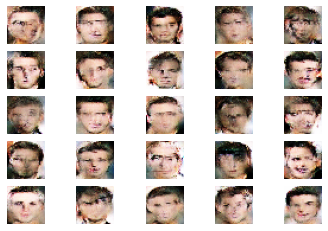

In [40]:
# Now, let us load the generator model and generate images
from tensorflow.keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()


    
load = "celebFaceGenerator_"+ str(epochs_trial)+ "epochs_4batch.h5"
# load model
model = load_model(load)
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)

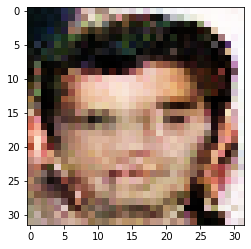

In [41]:
plt.imshow(X[2])
